<a href="https://colab.research.google.com/github/annissag/DTSA5509/blob/main/Supervised_Learning_Deliverable_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DTSA5509 Final Project Model

Background: With the increase in electric vehicle use, this project will be focusing on the sales of electric vehicles globally. This requires a supervised learning approach and there will be some logistic regression modeling included as well as linear regression and support vector machine algorithms to track the data.
This will help answer questions as to whether the switch to electric vehicles will withhold globally, or if it was a quick burst that still requires further development before a majority of the world population begins adopting electric vehicles as their daily commuter cars.



---

Import data from Kaggle for Electric Vehicle Sales

Data Source: Edson Marin. (2023). Historic sales of electric vehicles [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/5672792
---

The dataset includes 8 columns including region, category (historical), parameter (electric vehicle sales), mode (cars), powertrain (battery electric vehicle (BEV) or plug-in hybrid electric vehicle (PHEV)), year, unit (vehicles), and value (amount of vehicle sales). It is a single table provided by a data scientist who gathered the data from the Global EV Outlook, an annual publication.

Import Necessary Libraries

In [1]:
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Import Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("edsonmarin/historic-sales-of-electric-vehicles")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/IEA-EV-dataEV salesCarsHistorical.csv")

100%|██████████| 4.51k/4.51k [00:00<00:00, 3.54MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/edsonmarin/historic-sales-of-electric-vehicles/versions/1




---


Data Cleanup


---

Data was cleaned to exclude PHEVs from the data, since they still use gasoline and are at the intersect of being both a gasoline and electric vehicle. However, I am more interested in how specifically battery electric vehicle sales are trending globally. I would also like to rename "value" to "Amount of Vehicle Sales" so it doesn't get confused with a monetary value.

In [3]:
df.rename(columns = {'value': 'Amount of Vehicle Sales'}, inplace = True)

print("Number of rows before removing PHEV:", len(df))

df = df[df["powertrain"] != "PHEV"]

print("Number of rows after removing PHEV:", len(df))

df.head()

Number of rows before removing PHEV: 834
Number of rows after removing PHEV: 443


,region,category,parameter,mode,powertrain,year,unit,Amount of Vehicle Sales
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49
1,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170
4,Australia,Historical,EV sales,Cars,BEV,2013,Vehicles,190
5,Australia,Historical,EV sales,Cars,BEV,2014,Vehicles,370
8,Australia,Historical,EV sales,Cars,BEV,2015,Vehicles,760




---

Exploratory Data Analysis (EDA)


---

Since I am currently unsure of how the data looks, some exploratory data analysis will be completed to help with the visualization of the data prior to processing. This includes creating a correlation matrix and corresponding heat map to see if there is a correlation visually.

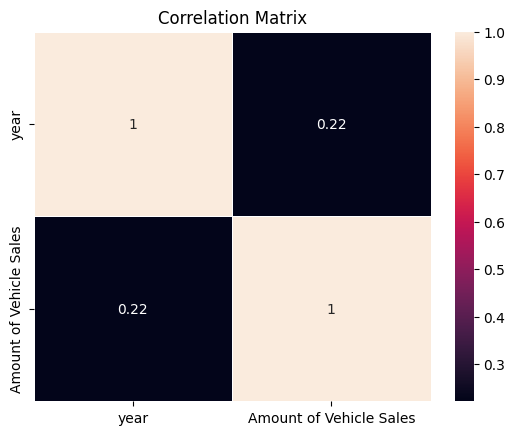

In [4]:
numeric_df = df.select_dtypes(include = ['float64', 'int64'])

corr_matrix = numeric_df.corr()

corr_matrix

sns.heatmap(corr_matrix, annot = True, linewidths = 0.5)
plt.title("Correlation Matrix")
plt.show()

As seen from this, there is not really any helpful information for this. I will continue trying other methods as learned from the course, including with a pairplot.

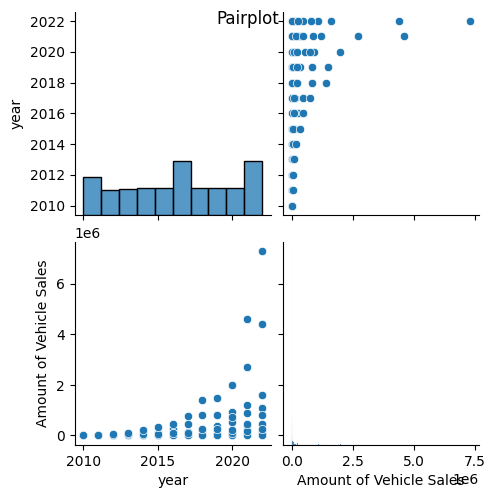

In [5]:
sns.pairplot(numeric_df)
plt.suptitle("Pairplot")
plt.show()

This rough plot shows that vehicle sales seemed to increase over time as suspected, so now it's time to dive deeper into this. There is a point, however, where it seems that EV sales may have peaked and fallen, so this will definitely require further analysis.

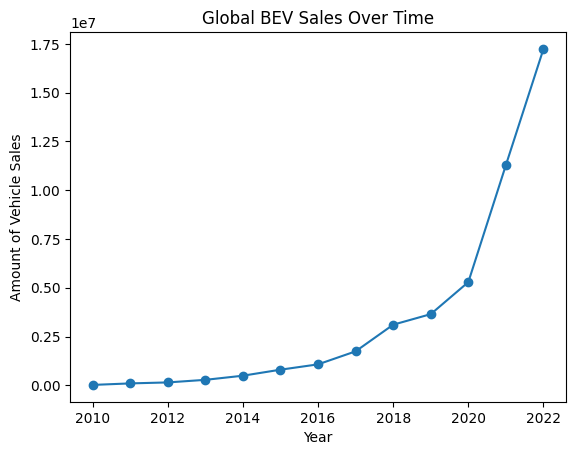

In [6]:
df_bev = df[df['powertrain'] == 'BEV']

sales_per_year = df_bev.groupby('year')['Amount of Vehicle Sales'].sum().reset_index()

plt.plot(sales_per_year['year'], sales_per_year['Amount of Vehicle Sales'], marker = 'o')
plt.title('Global BEV Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Amount of Vehicle Sales')
plt.show()

This simple plot shows what I am interested in looking for in a much simpler fashion.



---

Modeling with a Logistic Regression Model


---

Now, we will be using a logistic regression model on the data to see if based on the data, there is a prediction for how EV sales will continue globally.

In [7]:
# Setting Variables

x = sales_per_year[['year']]
y = sales_per_year['Amount of Vehicle Sales']

poly = PolynomialFeatures(degree = 3)
x_poly = poly.fit_transform(x)

# Starting the model

model = LinearRegression()
model.fit(x_poly, y)

y_pred = model.predict(x_poly)

future_years = np.arange(2023, 2028).reshape(-1, 1)
future_years_poly = poly.transform(future_years)
predicted_sales = model.predict(future_years_poly)

# Measuring average errors

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

Mean Absolute Error: 567197.4254807692
Mean Squared Error: 482526090743.5142
Root Mean Squared Error: 694640.9797467424
R2 Score: 0.9806169173306662


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


As seen from the average rates of errors, it seems that there is an average of about 500,000 predicted yearly BEV sales off compared to the actual sales. The R2 score, however, is relatively high meaning that most of the trend is supported by data. Next, a plot will be added for visualization to see how the model is. Potentially, once it is 2027, we can update this data to see if the model predicted correctly.

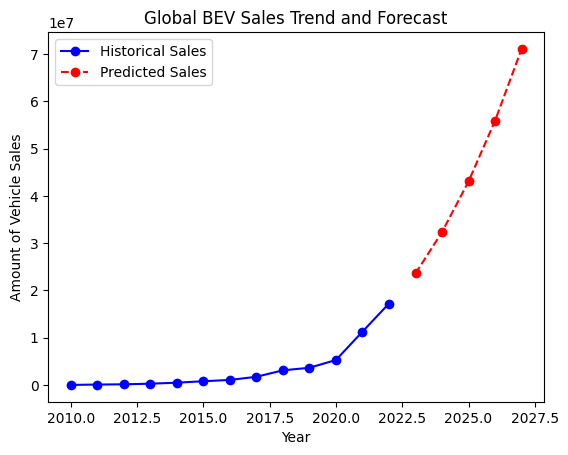

In [8]:
plt.plot(x, y, 'bo-', label = 'Historical Sales')
plt.plot(future_years, predicted_sales, 'ro--', label = 'Predicted Sales')
plt.title('Global BEV Sales Trend and Forecast')
plt.xlabel('Year')
plt.ylabel('Amount of Vehicle Sales')
plt.legend()
plt.show()

Based on this model that has been visualized, BEV sales are expected to increase significantly globally over the coming years. Next, potential overfitting will be addressed by using train/test splits on more recent years.

In [9]:
# Adding a train and test split

train = df_bev[df_bev['year'] <= 2020]
test = df_bev[df_bev['year'] > 2020]

x_train = train[['year']]
y_train = train['Amount of Vehicle Sales']

x_test = test[['year']]
y_test = test['Amount of Vehicle Sales']

# Now doing a polynomial regression to better fit the data

poly = PolynomialFeatures(degree = 2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Now adding the linear regression model

model = LinearRegression()
model.fit(x_train_poly, y_train)

# Adding predictions

y_train_pred = model.predict(x_train_poly)
y_test_pred = model.predict(x_test_poly)

# Evaluating to see the average errors

def print_metrics(y_true, y_pred, dataset_name = ""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} MAE: {mae}")
    print(f"{dataset_name} RMSE: {rmse}")
    print(f"{dataset_name} R2 Score: {r2}")

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_test, y_test_pred, "Test")

Train MAE: 66064.39808154042
Train RMSE: 176897.8715094852
Train R2 Score: 0.06423091079501086
Test MAE: 456650.1284851498
Test RMSE: 1177860.2047293456
Test R2 Score: -0.026757109574435667


The values produced by the calculations show that there is underfitting happening in the model, meaning that EV sales may be even higher than can be seen visually.



---
Analysis


---


Overall, it can be seen that the linear regression model was able to predict how BEV sales will continue to increase in the coming years, up to the year 2027. With the last plot, this trend shows a great increase. Different evaluation metrics also showed that with the high R2 value, the model is supported by the data. Please see the summary tables below.

In [10]:
def get_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  r2 = r2_score(y_true, y_pred)

  return {"MAE": mae, "RMSE": rmse, "R2 Score": r2}

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)

summary_table = pd.DataFrame({
    "Metrics": ["MAE", "RMSE", "R2 Score"],
    "Train": [train_metrics["MAE"], train_metrics["RMSE"], train_metrics["R2 Score"]],
    "Test": [test_metrics["MAE"], test_metrics["RMSE"], test_metrics["R2 Score"]]
})

print(summary_table)

    Metrics          Train          Test
0       MAE   66064.398082  4.566501e+05
1      RMSE  176897.871509  1.177860e+06
2  R2 Score       0.064231 -2.675711e-02




---
Conclusion


---

In conclusion, the model is supported by data that BEV sales will increase globally in the coming years. This data was shown to be underfitted in the last code section, meaning that the model may in fact be underwhelming compared to how global BEV sales will actually increase. Some takeaways from this project are that exploratory data analysis can help greatly in determining which model to use, and that showing the evaluation metrics along the way may paint a better picture of what is happening in the data. To improve this model, some further steps can be taken such as tracking more recent data up to 2025, and creating the model on that so that there is more data available for the model. Now that many states in the US are removing the tax rebate policies for EV, it would also be interesting to see how this is affecting BEV sales for the US especially. Most of the steps along the way for creating this model worked, but it would help more to have more data since it is a clean upward trend. This seems unlikely when looking at other linear regression models.